<a href="https://colab.research.google.com/github/roshantac/ERA/blob/main/temp/basic_utilities.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
A.!nvidia-smi

Sun Jul  9 16:08:52 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [41]:
##########################-----Utils-----############################

import cv2
import torch

layer_finders = {}


def register_layer_finder(model_type):
    def register(func):
        layer_finders[model_type] = func
        return func
    return register


def visualize_cam(mask, img, alpha=.80):
    """Make heatmap from mask and synthesize GradCAM result image using heatmap and img.
    Args:
        mask (torch.tensor): mask shape of (1, 1, H, W) and each element has value in range [0, 1]
        img (torch.tensor): img shape of (1, 3, H, W) and each pixel value is in range [0, 1]
    Return:
        heatmap (torch.tensor): heatmap img shape of (3, H, W)
        result (torch.tensor): synthesized GradCAM result of same shape with heatmap.
    """
    heatmap = (255 * mask.squeeze()).type(torch.uint8).cpu().numpy()
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    heatmap = torch.from_numpy(heatmap).permute(2, 0, 1).float().div(255)
    b, g, r = heatmap.split(1)
    heatmap = torch.cat([r, g, b]) * alpha

    result = heatmap+img.cpu()
    result = result.div(result.max()).squeeze()

    return heatmap, result


@register_layer_finder('resnet')
def find_resnet_layer(arch, target_layer_name):
    """Find resnet layer to calculate GradCAM and GradCAM++
    Args:
        arch: default torchvision densenet models
        target_layer_name (str): the name of layer with its hierarchical information. please refer to usages below.
            target_layer_name = 'conv1'
            target_layer_name = 'layer1'
            target_layer_name = 'layer1_basicblock0'
            target_layer_name = 'layer1_basicblock0_relu'
            target_layer_name = 'layer1_bottleneck0'
            target_layer_name = 'layer1_bottleneck0_conv1'
            target_layer_name = 'layer1_bottleneck0_downsample'
            target_layer_name = 'layer1_bottleneck0_downsample_0'
            target_layer_name = 'avgpool'
            target_layer_name = 'fc'
    Return:
        target_layer: found layer. this layer will be hooked to get forward/backward pass information.
    """
    if 'layer' in target_layer_name:
        hierarchy = target_layer_name.split('_')
        layer_num = int(hierarchy[0].lstrip('layer'))
        if layer_num == 1:
            target_layer = arch.layer1
        elif layer_num == 2:
            target_layer = arch.layer2
        elif layer_num == 3:
            target_layer = arch.layer3
        elif layer_num == 4:
            target_layer = arch.layer4
        else:
            raise ValueError('unknown layer : {}'.format(target_layer_name))

        if len(hierarchy) >= 2:
            bottleneck_num = int(hierarchy[1].lower().lstrip('bottleneck').lstrip('basicblock'))
            target_layer = target_layer[bottleneck_num]

        if len(hierarchy) >= 3:
            target_layer = target_layer._modules[hierarchy[2]]

        if len(hierarchy) == 4:
            target_layer = target_layer._modules[hierarchy[3]]

    else:
        target_layer = arch._modules[target_layer_name]

    return target_layer


@register_layer_finder('densenet')
def find_densenet_layer(arch, target_layer_name):
    """Find densenet layer to calculate GradCAM and GradCAM++
    Args:
        arch: default torchvision densenet models
        target_layer_name (str): the name of layer with its hierarchical information. please refer to usages below.
            target_layer_name = 'features'
            target_layer_name = 'features_transition1'
            target_layer_name = 'features_transition1_norm'
            target_layer_name = 'features_denseblock2_denselayer12'
            target_layer_name = 'features_denseblock2_denselayer12_norm1'
            target_layer_name = 'features_denseblock2_denselayer12_norm1'
            target_layer_name = 'classifier'
    Return:
        target_layer: found layer. this layer will be hooked to get forward/backward pass information.
    """

    hierarchy = target_layer_name.split('_')
    target_layer = arch._modules[hierarchy[0]]

    if len(hierarchy) >= 2:
        target_layer = target_layer._modules[hierarchy[1]]

    if len(hierarchy) >= 3:
        target_layer = target_layer._modules[hierarchy[2]]

    if len(hierarchy) == 4:
        target_layer = target_layer._modules[hierarchy[3]]

    return target_layer


@register_layer_finder('vgg')
def find_vgg_layer(arch, target_layer_name):
    """Find vgg layer to calculate GradCAM and GradCAM++
    Args:
        arch: default torchvision densenet models
        target_layer_name (str): the name of layer with its hierarchical information. please refer to usages below.
            target_layer_name = 'features'
            target_layer_name = 'features_42'
            target_layer_name = 'classifier'
            target_layer_name = 'classifier_0'
    Return:
        target_layer: found layer. this layer will be hooked to get forward/backward pass information.
    """
    hierarchy = target_layer_name.split('_')

    if len(hierarchy) >= 1:
        target_layer = arch.features

    if len(hierarchy) == 2:
        target_layer = target_layer[int(hierarchy[1])]

    return target_layer


@register_layer_finder('alexnet')
def find_alexnet_layer(arch, target_layer_name):
    """Find alexnet layer to calculate GradCAM and GradCAM++
    Args:
        arch: default torchvision densenet models
        target_layer_name (str): the name of layer with its hierarchical information. please refer to usages below.
            target_layer_name = 'features'
            target_layer_name = 'features_0'
            target_layer_name = 'classifier'
            target_layer_name = 'classifier_0'
    Return:
        target_layer: found layer. this layer will be hooked to get forward/backward pass information.
    """
    hierarchy = target_layer_name.split('_')

    if len(hierarchy) >= 1:
        target_layer = arch.features

    if len(hierarchy) == 2:
        target_layer = target_layer[int(hierarchy[1])]

    return target_layer


@register_layer_finder('squeezenet')
def find_squeezenet_layer(arch, target_layer_name):
    """Find squeezenet layer to calculate GradCAM and GradCAM++
    Args:
        arch: default torchvision densenet models
        target_layer_name (str): the name of layer with its hierarchical information. please refer to usages below.
            target_layer_name = 'features_12'
            target_layer_name = 'features_12_expand3x3'
            target_layer_name = 'features_12_expand3x3_activation'
    Return:
        target_layer: found layer. this layer will be hooked to get forward/backward pass information.
    """
    hierarchy = target_layer_name.split('_')
    target_layer = arch._modules[hierarchy[0]]

    if len(hierarchy) >= 2:
        target_layer = target_layer._modules[hierarchy[1]]

    if len(hierarchy) == 3:
        target_layer = target_layer._modules[hierarchy[2]]

    elif len(hierarchy) == 4:
        target_layer = target_layer._modules[hierarchy[2]+'_'+hierarchy[3]]

    return target_layer


def denormalize(tensor, mean, std):
    if not tensor.ndimension() == 4:
        raise TypeError('tensor should be 4D')

    mean = torch.FloatTensor(mean).view(1, 3, 1, 1).expand_as(tensor).to(tensor.device)
    std = torch.FloatTensor(std).view(1, 3, 1, 1).expand_as(tensor).to(tensor.device)

    return tensor.mul(std).add(mean)


def normalize(tensor, mean, std):
    if not tensor.ndimension() == 4:
        raise TypeError('tensor should be 4D')

    mean = torch.FloatTensor(mean).view(1, 3, 1, 1).expand_as(tensor).to(tensor.device)
    std = torch.FloatTensor(std).view(1, 3, 1, 1).expand_as(tensor).to(tensor.device)

    return tensor.sub(mean).div(std)


class Normalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        return self.do(tensor)

    def do(self, tensor):
        return normalize(tensor, self.mean, self.std)

    def undo(self, tensor):
        return denormalize(tensor, self.mean, self.std)

    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

In [42]:
###############################---Grad Cam --------------------------
import torch
import torch.nn.functional as F
#from utils import layer_finders
import PIL
import numpy as np
from torchvision import transforms
#from utils import visualize_cam
#from model import *

class GradCAM:


    def __init__(self, arch: torch.nn.Module, target_layer: torch.nn.Module):
        self.model_arch = arch

        self.gradients = dict()
        self.activations = dict()

        def backward_hook(module, grad_input, grad_output):
            self.gradients['value'] = grad_output[0]

        def forward_hook(module, input, output):
            self.activations['value'] = output

        target_layer.register_forward_hook(forward_hook)
        target_layer.register_backward_hook(backward_hook)

    @classmethod
    def from_config(cls, arch: torch.nn.Module, model_type: str, layer_name: str):
        target_layer = layer_finders[model_type](arch, layer_name)
        return cls(arch, target_layer)

    def saliency_map_size(self, *input_size):
        device = next(self.model_arch.parameters()).device
        self.model_arch(torch.zeros(1, 3, *input_size, device=device))
        return self.activations['value'].shape[2:]

    def forward(self, input, class_idx=None, retain_graph=False):
        b, c, h, w = input.size()

        logit = self.model_arch(input)
        if class_idx is None:
            score = logit[:, logit.max(1)[-1]].squeeze()
        else:
            score = logit[:, class_idx].squeeze()

        self.model_arch.zero_grad()
        score.backward(retain_graph=retain_graph)
        gradients = self.gradients['value']
        activations = self.activations['value']
        b, k, u, v = gradients.size()

        alpha = gradients.view(b, k, -1).mean(2)
        # alpha = F.relu(gradients.view(b, k, -1)).mean(2)
        weights = alpha.view(b, k, 1, 1)

        saliency_map = (weights*activations).sum(1, keepdim=True)
        saliency_map = F.relu(saliency_map)
        saliency_map = F.upsample(saliency_map, size=(h, w), mode='bilinear', align_corners=False)
        saliency_map_min, saliency_map_max = saliency_map.min(), saliency_map.max()
        saliency_map = (saliency_map - saliency_map_min).div(saliency_map_max - saliency_map_min).data

        return saliency_map, logit

    def __call__(self, input, class_idx=None, retain_graph=False):
        return self.forward(input, class_idx, retain_graph)




def show_map(img,model):
    target_model = model
    gradcam = GradCAM.from_config(model_type='resnet', arch=target_model, layer_name='layer4')
    img = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])(img)[None] #
    mask, logit = gradcam(img)
    heatmap, cam_result = visualize_cam(mask, img)
    return heatmap, cam_result

In [1]:
from tqdm import tqdm
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau
import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn
import torch
class train_test_evaluate:
  def __init__(self):
  ############################## Training  ###########################################
    self.train_losses = []
    self.test_losses = []
    self.train_acc = []
    self.test_acc = []

  def train(self,model, device, train_loader, optimizer, epoch):
    model.train()
    pbar = tqdm(train_loader)
    correct = 0
    processed = 0
    train_loss = 0
    criterion = nn.CrossEntropyLoss()
    for batch_idx, (data, target) in enumerate(pbar):
      # get samples
      data, target = data.to(device), target.to(device)

      # Init
      optimizer.zero_grad()
      # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
      # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.
      # Predict
      y_pred = model(data)

      # Calculate loss
      #loss = F.nll_loss(y_pred, target)
      loss = criterion(y_pred, target)
      #train_losses.append(loss)
      train_loss +=loss.item()
      # Backpropagation
      loss.backward()
      optimizer.step()
      # Update pbar-tqdm
      pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
      correct += pred.eq(target.view_as(pred)).sum().item()
      processed += len(data)
      pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    self.train_losses.append(loss.item()) # train_loss
    self.train_acc.append(100*correct/processed)
    #return train_losses, train_acc

  def test(self,model, device, test_loader):
      model.eval()
      test_loss = 0
      correct = 0
      criterion = nn.CrossEntropyLoss()
      with torch.no_grad():
          for data, target in test_loader:
              data, target = data.to(device), target.to(device)
              output = model(data)
              #test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
              test_loss += criterion(output, target).item()
              pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
              correct += pred.eq(target.view_as(pred)).sum().item()

      test_loss /= len(test_loader.dataset)
      self.test_losses.append(test_loss)

      print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
          test_loss, correct, len(test_loader.dataset),
          100. * correct / len(test_loader.dataset)))

      self.test_acc.append(100. * correct / len(test_loader.dataset))
      return test_loss

  def update_lr(self,optimizer, lr):
      for g in optimizer.param_groups:
          g['lr'] = lr


  def OneCyclePolicy(self,LRmax, step, iterations):
      LRmin = LRmax/10;
      LRt = LRmin
      LRvalues =[]
      for x in range(iterations):
          if (x<=step):
            LRt += (LRmax - LRmin)/step
            LRvalues.append(LRt)
          else:
            LRt -= (LRmax - LRmin)/(iterations-step)
            LRvalues.append(LRt)
      return LRvalues



  def Training(self,epochs,model,device, trainloader, testloader, LR):
    Testloss = 0
    LRvalues = self.OneCyclePolicy(LR, 5, epochs)
    optimizer = optim.SGD(model.parameters(), lr=LR, momentum=0.95)
    #scheduler = ReduceLROnPlateau(optimizer, 'min') #StepLR(optimizer, step_size=6, gamma=0.1)
    for epoch in range(epochs):
        print("EPOCH:", epoch)
        self.update_lr(optimizer,LRvalues[epoch])
        self.train(model, device, trainloader, optimizer, epoch)
        Testloss = self.test(model, device, testloader)
        #scheduler.step(Testloss)

  def plotPerformanceGraph(self):
    import matplotlib.pyplot as plt
    fig, (axs1,axs2) = plt.subplots(2, 1,figsize=(15,10))

    axs1.plot(self.train_losses, label = " Train Loss")
    axs1.plot(self.test_losses, label = " Test Loss")
    axs1.set_title(" Loss")

    axs2.plot(self.train_acc, label = " Train Accuracy")
    axs2.plot(self.test_acc, label = " Test Accuracy")

    axs2.set_title(" Accuracy")
    axs1.legend()
    axs2.legend()
    plt.show()

  def MissClassifedImage(self,dataSet, model,device, dispCount,classes):
    import matplotlib.pyplot as plt
    import numpy as np
    import math

    dataiter = iter(dataSet)
    fig, axs = plt.subplots(int(math.ceil(dispCount/5)),5,figsize=(10,10))
    fig.tight_layout()
    count =0
    while True:
        if count >= dispCount:
          break
        images, labels = next(dataiter)
        imagex = images
        images, labels = images.to(device), labels.to(device)
        model= model.to(device)
        output = model(images)
        a, predicted = torch.max(output, 1)
        if(labels != predicted):
          imagex = imagex.squeeze()
          imagex = np.transpose(imagex, (1, 2, 0))
          axs[int(count/5), count%5].imshow(imagex)
          axs[int(count/5), count%5].set_title("Orig: "+str(classes[labels])+", Pred: "+str(classes[predicted]))
          fig.tight_layout(pad=3.0)
          count = count +1
    plt.show()

  def ClassTestAccuracy(self,testloader,device,model, classes):
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images =images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            c = (predicted == labels).squeeze()
            for i in range(4):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1


    for i in range(10):
        print('Accuracy of %5s : %2d %%' % (
            classes[i], 100 * class_correct[i] / class_total[i]))




In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion*planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNet18():
    return ResNet(BasicBlock, [2,2,2,2])

def ResNet34():
    return ResNet(BasicBlock, [3,4,6,3])

def ResNet50():
    return ResNet(Bottleneck, [3,4,6,3])

def ResNet101():
    return ResNet(Bottleneck, [3,4,23,3])

def ResNet152():
    return ResNet(Bottleneck, [3,8,36,3])


# def test():
#     net = ResNet18()
#     y = net(torch.randn(1,3,32,32))
#     print(y.size())


def ResBlock(channel_no): # as per rohans question
  return nn.Sequential(
  nn.Conv2d(in_channels = channel_no, out_channels = channel_no, kernel_size = (3,3), padding=1, dilation =1),
  nn.BatchNorm2d(channel_no),
  nn.ReLU(),
  nn.Conv2d(in_channels = channel_no, out_channels = channel_no, kernel_size = (3,3), padding=1, dilation =1),
  nn.BatchNorm2d(channel_no),
  nn.ReLU()
  )

def ConvI(inChannels, outChannels,kernel=3, padding=1, b_bias=False):
  return nn.Sequential(
      nn.Conv2d(in_channels=inChannels, out_channels=outChannels,
                kernel_size=(kernel, kernel), padding=padding, bias=b_bias),
      nn.BatchNorm2d(outChannels),
      nn.ReLU(),
  )
def ConvII(inChannels, outChannels,kernel=3, padding=1):
  return nn.Sequential(
      nn.Conv2d(in_channels=inChannels, out_channels=outChannels,
                kernel_size=(kernel, kernel), padding=padding),
      nn.MaxPool2d(2, 2),
      nn.BatchNorm2d(outChannels),
      nn.ReLU(),
  )
def Maxpooling(kernel):
  return nn.MaxPool2d(kernel, kernel)



class Model11(nn.Module):
  def __init__(self):
      super(Model11, self).__init__()
      self.Preplayer = ConvI(3, 64)
      #layer 1
      self.ConvPool1 = ConvII(64, 128)
      self.Res1 = ResBlock(128)
      #layer 2
      self.ConvPool2 = ConvII(128, 256)
      #layer 3
      self.ConvPool3 = ConvII(256, 512)
      self.Res2 = ResBlock(512)
      #layer 4
      self.Pool = Maxpooling(4)
      self.FC   = nn.Linear(512, 10)


  def forward(self,x):
    X = self.Preplayer(x) #32
    X = self.ConvPool1(X)
    R1 = self.Res1(X)     #16
    X = self.ConvPool2(X + R1)
    X = self.ConvPool3(X)
    R2 = self.Res2(X)
    X = self.Pool(X+R2 )
    X = X.view(-1,512)
    X = self.FC(X)
    return F.log_softmax(X, dim= -1)

In [ ]:
# Assignment S8 with Layer Normalization (with CIFAR10 Dataset - Image size 32 x 32)

class Model_Layer_Normalization(nn.Module):
    def __init__(self):
        super(Model_Layer_Normalization, self).__init__()
        dout = 0.1
        # Input Block with convolution C1
        self.convblock_C1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.GroupNorm(1,8),
            nn.Dropout(dout)
        ) # output_size = 32

        # CONVOLUTION BLOCK 1 C2
        self.convblock_C2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.GroupNorm(1,8),
            nn.Dropout(dout)
        ) # output_size = 32

        # TRANSITION BLOCK 1 c3
        self.convblock_c3 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=7, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 32
        # P1
        self.pool_P1 = nn.MaxPool2d(2, 2)
        # output_size = 16

        # CONVOLUTION BLOCK 2 C3
        self.convblock_C3 = nn.Sequential(
            nn.Conv2d(in_channels=7, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.GroupNorm(1,16),
            nn.Dropout(dout)
        ) # output_size = 16

        self.convblock_C4 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.GroupNorm(1,16),
            nn.Dropout(dout)
        ) # output_size = 16

        self.convblock_C5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.GroupNorm(1,16),
            nn.Dropout(dout)
        )
            # output_size = 16

        # TRANSITION BLOCK 2 c6
        self.convblock_c6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 16
        # P2
        self.pool_P2 = nn.MaxPool2d(2, 2)
        # output_size = 8

        # CONVOLUTION BLOCK 3 C7
        self.convblock_C7 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=32, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.GroupNorm(1,32),
            nn.Dropout(dout)
        ) # output_size = 8

        self.convblock_C8 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.GroupNorm(1,32),
            nn.Dropout(dout)
        ) # output_size = 8

        self.convblock_C9 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU())
            # output_size = 8

        # OUTPUT BLOCK GAP
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=8)
        )

        #CONVOLUTION BLOCK C10
        self.convblock_C10 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        )

        self.dropout = nn.Dropout(dout)

    def forward(self, x):
        x = self.convblock_C1(x)
        x = x + self.convblock_C2(x)
        x = self.convblock_c3(x) # 1 x 1
        x = self.pool_P1(x)
        x = self.convblock_C3(x)
        x = x + self.convblock_C4(x)
        x = x + self.convblock_C5(x)
        x = self.convblock_c6(x) # 1 x 1
        x = self.pool_P2(x)
        x = self.convblock_C7(x)
        x = x + self.convblock_C8(x)
        x = x + self.convblock_C9(x)
        x = self.gap(x)
        x = self.convblock_C10(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Assignment S8 with Group Normalization (with CIFAR10 Dataset - Image size 32 x 32)

class Model_Group_Normalization(nn.Module):
    def __init__(self):
        super(Model_Group_Normalization, self).__init__()
        dout = 0.1
        # Input Block with convolution C1
        self.convblock_C1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.GroupNorm(4,8),
            nn.Dropout(dout)
        ) # output_size = 32

        # CONVOLUTION BLOCK 1 C2
        self.convblock_C2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.GroupNorm(4,8),
            nn.Dropout(dout)
        ) # output_size = 32

        # TRANSITION BLOCK 1 c3
        self.convblock_c3 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=7, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 32
        # P1
        self.pool_P1 = nn.MaxPool2d(2, 2)
        # output_size = 16

        # CONVOLUTION BLOCK 2 C3
        self.convblock_C3 = nn.Sequential(
            nn.Conv2d(in_channels=7, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.GroupNorm(4,16),
            nn.Dropout(dout)
        ) # output_size = 16

        self.convblock_C4 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.GroupNorm(4,16),
            nn.Dropout(dout)
        ) # output_size = 16

        self.convblock_C5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.GroupNorm(4,16),
            nn.Dropout(dout)
        )
            # output_size = 16

        # TRANSITION BLOCK 2 c6
        self.convblock_c6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 16
        # P2
        self.pool_P2 = nn.MaxPool2d(2, 2)
        # output_size = 8

        # CONVOLUTION BLOCK 3 C7
        self.convblock_C7 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=32, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.GroupNorm(4,32),
            nn.Dropout(dout)
        ) # output_size = 8

        self.convblock_C8 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.GroupNorm(4,32),
            nn.Dropout(dout)
        ) # output_size = 8

        self.convblock_C9 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU())
            # output_size = 8

        # OUTPUT BLOCK GAP
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=8)
        )

        #CONVOLUTION BLOCK C10
        self.convblock_C10 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        )

        self.dropout = nn.Dropout(dout)

    def forward(self, x):
        x = self.convblock_C1(x)
        x = x + self.convblock_C2(x)
        x = self.convblock_c3(x) # 1 x 1
        x = self.pool_P1(x)
        x = self.convblock_C3(x)
        x = x + self.convblock_C4(x)
        x = x + self.convblock_C5(x)
        x = self.convblock_c6(x) # 1 x 1
        x = self.pool_P2(x)
        x = self.convblock_C7(x)
        x = x + self.convblock_C8(x)
        x = x + self.convblock_C9(x)
        x = self.gap(x)
        x = self.convblock_C10(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

In [3]:
##########################---Dataset--#############################
import torch
import torchvision
import torchvision.transforms as transforms
#import Albumentation

import numpy as np
from albumentations import Compose, RandomCrop,PadIfNeeded, Normalize, HorizontalFlip,HueSaturationValue,Cutout,ShiftScaleRotate
import albumentations as A
from albumentations.pytorch import ToTensorV2
#from albumentations.pytorch import ToTensor
import cv2


class album_Compose:
  def __init__(self):
    self.alb_transform =A.Compose([
      A.PadIfNeeded(min_height=32, min_width=32, border_mode=cv2.BORDER_CONSTANT, value=4, always_apply=False, p=.50),
      A.RandomCrop(32, 32, always_apply=False, p=.50),A.HorizontalFlip(),
      A.HueSaturationValue(hue_shift_limit=4, sat_shift_limit=13, val_shift_limit=9),
      A.Cutout(num_holes=1, max_h_size=8, max_w_size=8),
      A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.2,rotate_limit=13, p=0.6),

      A.Normalize(
        mean = [0.4914, 0.4822, 0.4465],
        std = [0.2023, 0.1994, 0.2010],
        ),
      ToTensorV2(),
      ],p=.8)
  def __call__(self,img):
    img = np.array(img)
    img = self.alb_transform(image=img)['image']
    return img


def getData():
  k= album_Compose()
  transform_test = transforms.Compose(
      [transforms.ToTensor(),
      transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])
  transform_train = transforms.Compose([
      transforms.RandomCrop(32, padding=4),
      transforms.RandomHorizontalFlip(), transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
      transforms.RandomRotation((-10.0, 10.0)), transforms.ToTensor(),
      transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
  ])
  trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                          download=True, transform=k)
  trainloader = torch.utils.data.DataLoader(trainset, batch_size= 500,
                                            shuffle=True, num_workers=2)

  testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=True, transform=transform_test)
  testloader = torch.utils.data.DataLoader(testset, batch_size=100,
                                          shuffle=False, num_workers=2)
  testset2 = torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=True, transform=transforms.Compose([transforms.ToTensor()]))
  testloader2 = torch.utils.data.DataLoader(testset2, batch_size=1,
                                          shuffle=False, num_workers=2)

  classes = ('plane', 'car', 'bird', 'cat',
            'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
  return trainloader, testloader,testloader2, classes

In [4]:
trainloader, testloader, testData, classes = getData()

/usr/local/lib/python3.10/dist-packages/albumentations/augmentations/dropout/cutout.py:50: FutureWarning: Cutout has been deprecated. Please use CoarseDropout
  warnings.warn(


100%|██████████| 170498071/170498071 [00:02<00:00, 79069951.73it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Files already downloaded and verified


In [5]:


########################################
#  Calling  heavenly Gods
########################################
import torch
import torchvision
import torchvision.transforms as transforms
from torchsummary import summary
# Utilize GPU if available
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = ResNet18().to(device)
# if device == 'cuda':
#     model = torch.nn.DataParallel(model)
#     cudnn.benchmark = True

# Print Model Summary
summary(model, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1,

In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-7)

In [8]:
# Training starts here
TTE = train_test_evaluate()
TTE.Training(2,model,device, trainloader, testloader,.01 )

EPOCH: 0


Loss=2.380920171737671 Batch_id=1 Accuracy=10.40:   2%|▏         | 2/100 [00:02<02:05,  1.28s/it]


RuntimeError: ignored

In [39]:


# Calsswise accuracy
TTE.ClassTestAccuracy(testloader,device,model,classes)



Accuracy of plane : 100 %
Accuracy of   car : 90 %
Accuracy of  bird : 57 %
Accuracy of   cat : 60 %
Accuracy of  deer : 79 %
Accuracy of   dog : 53 %
Accuracy of  frog : 77 %
Accuracy of horse : 90 %
Accuracy of  ship : 66 %
Accuracy of truck : 96 %


In [24]:
def MissClassifedImage(dataSet, model,device, dispCount,classes):
  dataiter = iter(dataSet)
  import matplotlib.pyplot as plt
  import numpy as np
  import math

  fig, axs = plt.subplots(int(math.ceil(dispCount/5)),5,figsize=(10,10))
  fig.tight_layout()
  count =0
  while True:
      if count >= dispCount:
        break
      images, labels = next(dataiter)
      imagex = images
      images, labels = images.to(device), labels.to(device)
      model= model.to(device)
      output = model(images)
      a, predicted = torch.max(output, 1)
      if(labels != predicted):
        imagex = imagex.squeeze()
        imagex = np.transpose(imagex, (1, 2, 0))
        axs[int(count/5), count%5].imshow(imagex)
        axs[int(count/5), count%5].set_title("Orig: "+str(classes[labels])+", Pred: "+str(classes[predicted]))
        fig.tight_layout(pad=3.0)
        count = count +1
  plt.show()

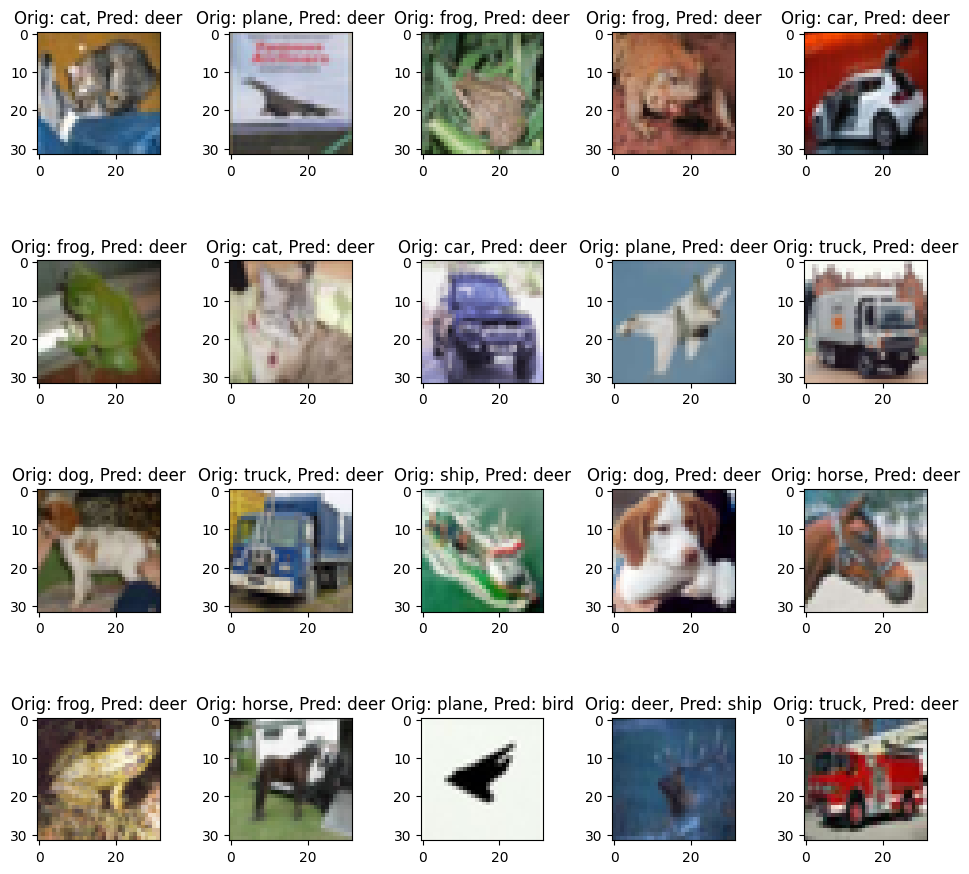

In [43]:
TTE.MissClassifedImage(testData,model,device,20,classes)

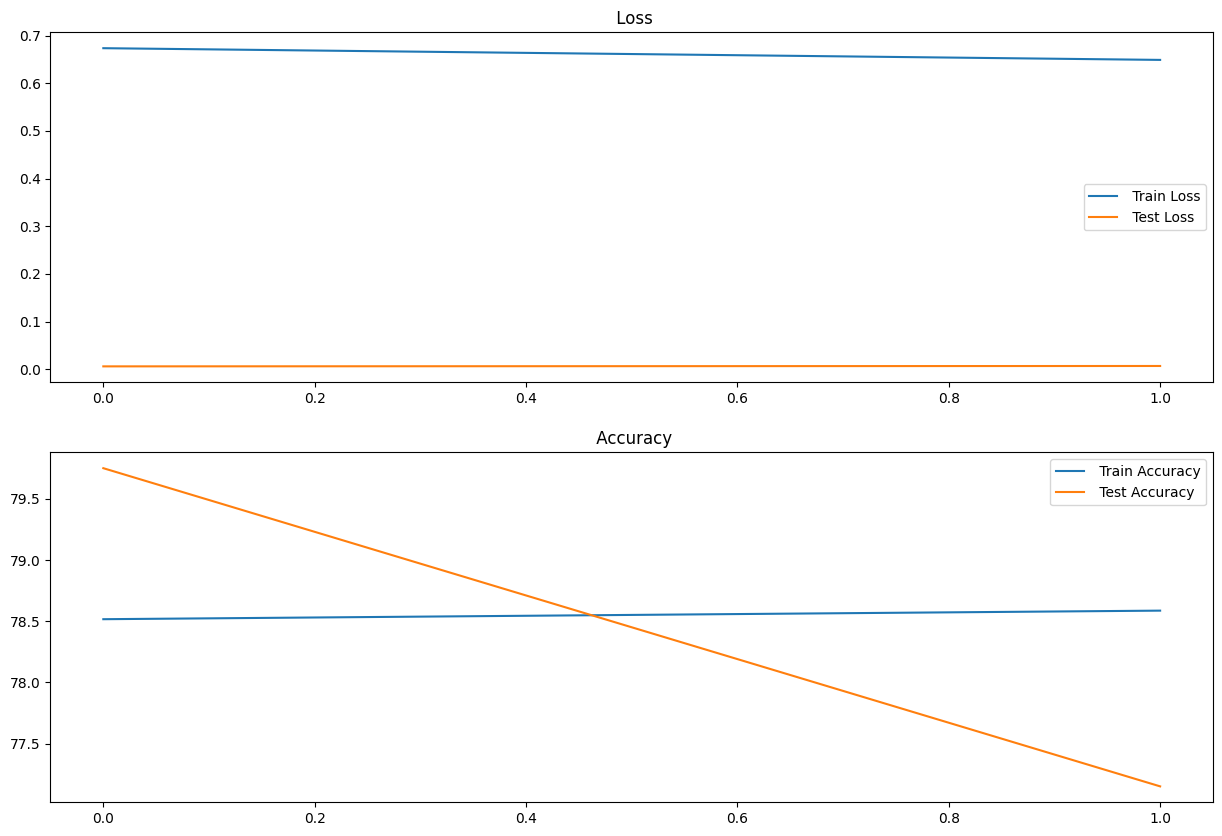

In [44]:

TTE.plotPerformanceGraph( )